In [24]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pycwt import cwt,xwt,wct,wct_significance,wavelet,Morlet
import matplotlib.dates as mdates
import pandas as pd
import os

from scipy.signal import detrend
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/graft_filled/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])

In [25]:
patho = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/wavelet/104m_wavelet/"

In [26]:
#ds40d = ds40.resample(TIME1='24h').mean()
s0 = 24
dt = 1
dj = 0.125
#J = int(np.log2(24*365*3 / s0) / dj)
mother = wavelet.Morlet(6.)

# find correlation between ss and 40 m biomass

In [5]:
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/graft_filled/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])

pathss = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/ss/"
filess = sorted([f for f in os.listdir(pathss) if f.endswith(".nc")])
ss = [xr.open_dataset(pathss+filess[i]) for i in range(7)]

bm = [xr.open_dataset(path+files[i]) for i in range(7)]

for i in range(7):
    ds104 = bm[i].sel(DEPTH=104,method="nearest")
    corr = xr.corr(ss[i].SS[:,0,0],ds104.BIOMASS[:,0,0])
    print(np.round(corr.values,4))

0.8537
0.8673
0.8129
0.7615
0.7667
0.7796
0.6335


# OKHA 

In [6]:
ds = xr.open_dataset(path+files[0])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS.values)



In [7]:
bm104d_1 = detrend(bm104d[0:10099,0,0])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


In [8]:
bm104d_2 = detrend(bm104d[18963:45401,0,0])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm104d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm104d_2)
alpha, _, _ = wavelet.ar1(bm104d_2)  # Lag-1 autocorrelation for red noise
std = bm104d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

Text(0, 0.5, 'period (days)')

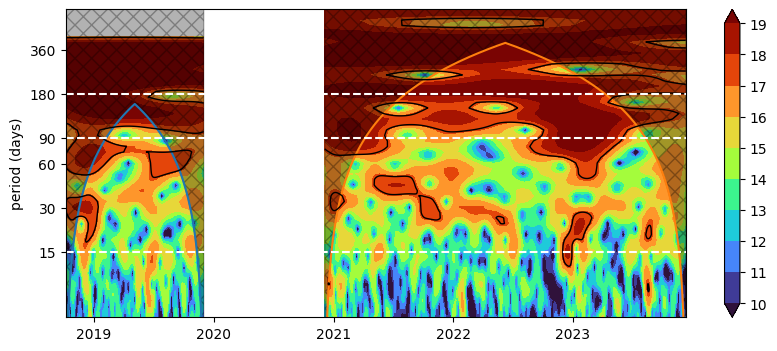

In [9]:
plt.figure(figsize=(10,4))

x = plt.contourf(ds104.TIME1[0:10099], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds104.TIME1[0:10099], np.log2(coi1))
plt.fill_between(ds104.TIME1[0:10099],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')
extent = [ds104.TIME1[0:10099].min(), ds104.TIME1[0:10099].max(), 0, max(period1)]
plt.contour(ds104.TIME1[0:10099], np.log2(period1), sig951,levels=[-99,1], colors='k', linewidths=1,extent=extent)

plt.contourf(ds104.TIME1[18963:45401], np.log2(period2), np.log2(power2), extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds104.TIME1[18963:45401], np.log2(coi2))
plt.fill_between(ds104.TIME1[18963:45401],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')
extent = [ds104.TIME1[18963:45401].min(), ds104.TIME1[18963:45401].max(), 0, max(period2)]
plt.contour(ds104.TIME1[18963:45401], np.log2(period2), sig952,levels=[-99,1], colors='k', linewidths=1,extent=extent)


plt.axhline(np.log2(24),color='w',linestyle='--')
plt.axhline(np.log2(24*15),color='w',linestyle='--')
plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')


plt.colorbar(x)

plt.ylim(7,14)
customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [11]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:10099].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[18963:45401].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1[0:10099].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds104.TIME1[18963:45401].values}
)

sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:10099].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[18963:45401].values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'sig1': sig1,
    'sig2': sig2,
    'coi1': ci1,
    'coi2': ci2,
})
ds.to_netcdf(patho+str(files[0]))

# for daily resampled data

In [ ]:
ds = xr.open_dataset(path+files[0])
ds40 = ds.sel(DEPTH=40,method="nearest").resample(TIME1='24h').mean()
bm40d = np.array(ds40.BIOMASS[:,0,0].values)

s0 = 2
dj = 0.01
#J = int(np.log2(24*365*3 / s0) / dj)
mother = wavelet.Morlet(6.)
bm40d_1 = detrend(bm40d[0:422])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

plt.contourf(ds40.TIME1[0:422], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,15,0.1))
#plt.contourf(wave1,cmap="turbo",levels=(np.arange(20,60,10)),extend="both")
plt.plot(ds40.TIME1[0:422], np.log2(coi1))
plt.fill_between(ds40.TIME1[0:422],np.log2(coi1),10,color='k',alpha=0.3,hatch='xx')
plt.colorbar()

# mumbai

In [12]:
ds = xr.open_dataset(path+files[1])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS[:,0,0].values)


In [13]:
bm104d_1 = detrend(bm104d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

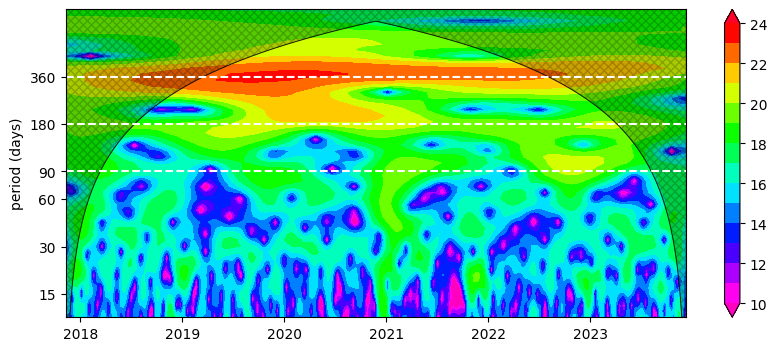

In [14]:
plt.figure(figsize=(10,4))

plt.contourf(ds104.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds104.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds104.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [15]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})

ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})

In [16]:
ds.to_netcdf(patho+str(files[1]))

# Jaigarh

##### different than jaigarh 40 m. in timeseries.

In [28]:
ds = xr.open_dataset(path+files[2])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS[:,0,0].values)


In [34]:
bm104d_1 = detrend(bm104d[0:17570])

In [30]:
bm104d_2 = detrend(bm104d[17689:38136])
bm104d_3 = detrend(bm104d[45460:54408])


In [56]:
bm104d_1 = detrend(bm104d[0:17570])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


bm104d_2 = detrend(bm104d[17689:38137])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm104d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm104d_2)
alpha, _, _ = wavelet.ar1(bm104d_2)  # Lag-1 autocorrelation for red noise
std = bm104d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

bm104d_3 = detrend(bm104d[45460:])
wave3, scales3, freqs3, coi3, fft3, fftfreqs3 = cwt(bm104d_3,dt=1,dj=dj,s0=12, J=-1, wavelet=mother)
power3 = (np.abs(wave3)) ** 3  # Wavelet power spectrum
period3 = 1 / freqs3  # Convert frequencies to periods
N = len(bm104d_3)
alpha, _, _ = wavelet.ar1(bm104d_3)  # Lag-1 autocorrelation for red noise
std = bm104d_3.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_3, dt, scales3, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig953 = np.ones([1, N]) * signif[:, None]
sig953 = power3 / sig953

Text(0, 0.5, 'period (days)')

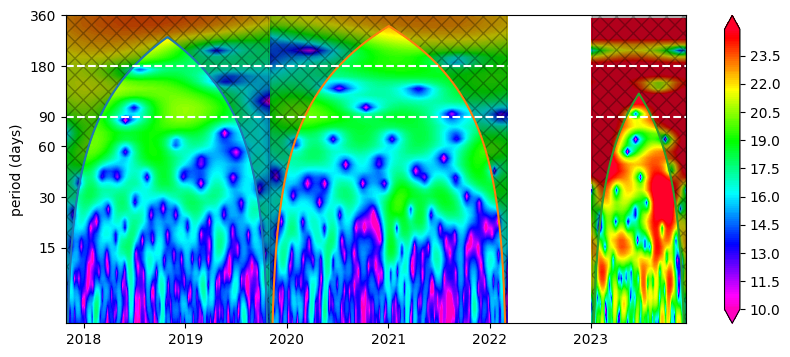

In [58]:
plt.figure(figsize=(10,4))
plt.contourf(ds104.TIME1[0:17570], np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds104.TIME1[0:17570], np.log2(coi1))
plt.fill_between(ds104.TIME1[0:17570],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds104.TIME1[17689:38137], np.log2(period2), np.log2(power2), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds104.TIME1[17689:38137], np.log2(coi2))
plt.fill_between(ds104.TIME1[17689:38137],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds104.TIME1[45460:], np.log2(period3), np.log2(power3), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds104.TIME1[45460:], np.log2(coi3))
plt.fill_between(ds104.TIME1[45460:],np.log2(coi3),16,color='k',alpha=0.3,hatch='xx')


plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')


plt.colorbar()
plt.ylim(7,12.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [60]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:17570].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[17689:38137].values})
wavpow3=xr.DataArray(
    data=power3,
    dims=["period","time"],
    coords={"period":period3,'time':ds104.TIME1[45460:54408].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1[0:17570].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds104.TIME1[17689:38137].values})
ci3=xr.DataArray(
    data=coi3,
    dims=["time"],
    coords={'time':ds104.TIME1[45460:54408].values}
)
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:17570].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[17689:38137].values})
sig3=xr.DataArray(
    data=sig953,
    dims=["period","time"],
    coords={"period":period3,'time':ds104.TIME1[45460:54408].values})


ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'wavpow3': wavpow3,
    'sig1': sig1,
    'sig2': sig2,
    'sig3': sig3,
    'coi1': ci1,
    'coi2': ci2,
    'coi3': ci3,
})

In [61]:
ds.to_netcdf(patho+str(files[2]))

# Goa

In [16]:
ds = xr.open_dataset(path+files[3])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS[:,0,0].values)

bm104d_1 = detrend(bm104d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

In [17]:
print(ds104.TIME1[-10:-1])

<xarray.DataArray 'TIME1' (TIME1: 9)> Size: 72B
array(['2023-12-13T22:00:00.000000000', '2023-12-13T23:00:00.000000000',
       '2023-12-14T00:00:00.000000000', '2023-12-14T01:00:00.000000000',
       '2023-12-14T02:00:00.000000000', '2023-12-14T03:00:00.000000000',
       '2023-12-14T04:00:00.000000000', '2023-12-14T05:00:00.000000000',
       '2023-12-14T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    DEPTH    float32 4B 104.0
  * TIME1    (TIME1) datetime64[ns] 72B 2023-12-13T22:00:00 ... 2023-12-14T06...
Attributes:
    long_name:      time1
    time_origin:    15-JAN-1901 00:00:00
    axis:           T
    standard_name:  time


Text(0, 0.5, 'period (days)')

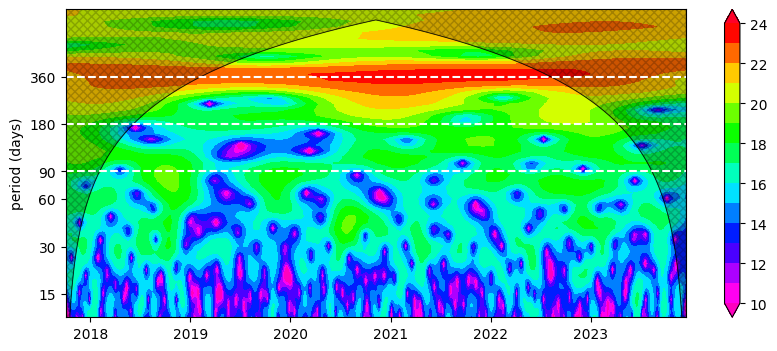

In [18]:
plt.figure(figsize=(10,4))

plt.contourf(ds104.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds104.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds104.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [19]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})


In [22]:
ds.to_netcdf(patho+str(files[3]))

# Udupi  

In [28]:
ds = xr.open_dataset(path+files[4])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS[:,0,0].values)


In [29]:
bm104d_1 = detrend(bm104d[0:27907])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


bm104d_2 = detrend(bm104d[38852:])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm104d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm104d_2)
alpha, _, _ = wavelet.ar1(bm104d_2)  # Lag-1 autocorrelation for red noise
std = bm104d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

Text(0, 0.5, 'period (days)')

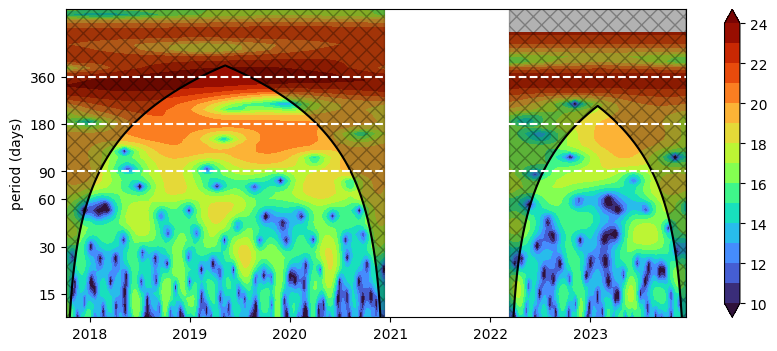

In [30]:
plt.figure(figsize=(10,4))
plt.contourf(ds104.TIME1[0:27907], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,25,1))
#plt.contourf(wave1,cmap="turbo",levels=(np.arange(20,60,10)),extend="both")
plt.plot(ds104.TIME1[0:27907], np.log2(coi1),color='k')
plt.fill_between(ds104.TIME1[0:27907],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds104.TIME1[38852:], np.log2(period2), np.log2(power2), extend='both',cmap="turbo",levels=np.arange(10,25,1))
plt.plot(ds104.TIME1[38852:], np.log2(coi2),color='k')
plt.fill_between(ds104.TIME1[38852:],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [31]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:27907].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[38852:].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1[0:27907].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds104.TIME1[38852:].values}
)

sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:27907].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[38852:].values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'sig1': sig1,
    'sig2': sig2,
    'coi1': ci1,
    'coi2': ci2,
})
ds.to_netcdf(patho+str(files[4]))

# Kollam

In [62]:
#### different than kollam 104m timeseries

In [63]:
ds = xr.open_dataset(path+files[5])
ds104 = ds.sel(DEPTH=104,method="nearest")
bm104d = np.array(ds104.BIOMASS[:,0,0].values)


In [112]:
bm104d_1 = detrend(bm104d[0:27909])

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


bm104d_2 = detrend(bm104d[38839:])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm104d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm104d_2)
alpha, _, _ = wavelet.ar1(bm104d_2)  # Lag-1 autocorrelation for red noise
std = bm104d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

Text(0, 0.5, 'period (days)')

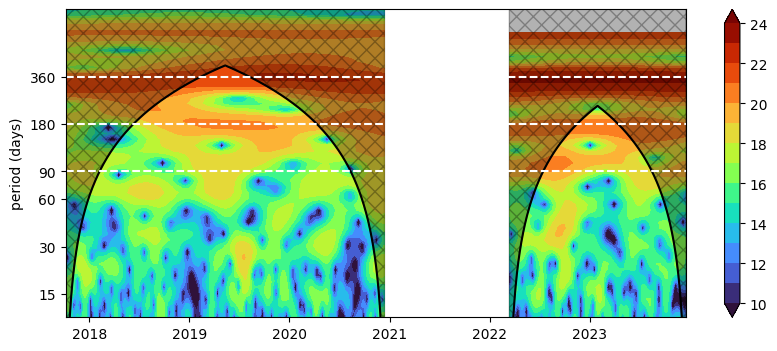

In [113]:
plt.figure(figsize=(10,4))
plt.contourf(ds104.TIME1[0:27909], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,25,1))
#plt.contourf(wave1,cmap="turbo",levels=(np.arange(20,60,10)),extend="both")
plt.plot(ds104.TIME1[0:27909], np.log2(coi1),color='k')
plt.fill_between(ds104.TIME1[0:27909],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds104.TIME1[38839:], np.log2(period2), np.log2(power2), extend='both',cmap="turbo",levels=np.arange(10,25,1))
plt.plot(ds104.TIME1[38839:], np.log2(coi2),color='k')
plt.fill_between(ds104.TIME1[38839:],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [114]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:27909].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[38839:].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1[0:27909].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds104.TIME1[38839:].values}
)

sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1[0:27909].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds104.TIME1[38839:].values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'sig1': sig1,
    'sig2': sig2,
    'coi1': ci1,
    'coi2': ci2,
})
ds.to_netcdf(patho+str(files[5]))

# Kanyakumari

In [115]:
## special case: the gap between consecutive deployment was more than 3 days, not filled by graft filling, so made spline interpolation and filled


In [4]:
ds = xr.open_dataset(path+files[6])


In [5]:
ds1041 = ds.sel(DEPTH=104,method="nearest")

In [6]:
ds104 = ds1041.interpolate_na(dim="TIME1",method="spline")

In [8]:
bm104d = np.array(ds104.BIOMASS[:,0,0].values)
bm104d_1 = detrend(bm104d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm104d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

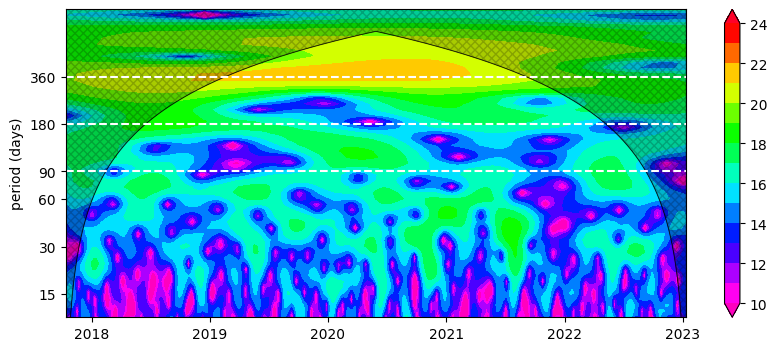

In [9]:
plt.figure(figsize=(10,4))

plt.contourf(ds104.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds104.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds104.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [10]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm104d_1)
alpha, _, _ = wavelet.ar1(bm104d_1)  # Lag-1 autocorrelation for red noise
std = bm104d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm104d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds104.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds104.TIME1.values})

ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})

ds.to_netcdf(patho+str(files[6]))

# OKHA data recreated

In [29]:
ds = xr.open_dataset(patho+"1okha_graftfill.nc")

Text(0, 0.5, 'period (days)')

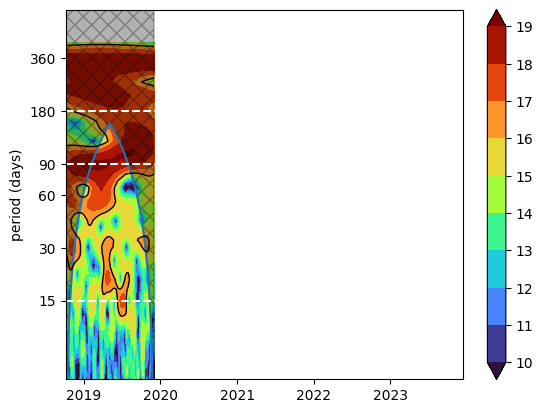

In [49]:
x = plt.contourf(ds.time,np.log2(ds.period),np.log2(ds.wavpow1),extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds.time, np.log2(ds.coi1))
plt.fill_between(ds.time, np.log2(ds.coi1),16,color='k',alpha=0.3,hatch='xx')

extent = [ds.time.min(), ds.time.max(), 0, max(ds.period)]
plt.contour(ds.time, np.log2(ds.period), ds.sig1,levels=[-99,1], colors='k', linewidths=1,extent=extent)
plt.ylim(7,13)

plt.axhline(np.log2(24),color='w',linestyle='--')
plt.axhline(np.log2(24*15),color='w',linestyle='--')
plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')


plt.colorbar(x)

plt.ylim(7,14)
customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")